In [1]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
from PIL import Image
import requests
import torch
import os
import matplotlib.pyplot as plt
import re

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'

In [3]:
# load the processor
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

In [4]:
# load the model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    #torch_dtype='auto',
    torch_dtype=torch.float16,
    device_map='auto'
)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
"""
Gibt zwei Arrays zurück, die jeweils die tasks (strings) bzw die Bilder enthalten.
Geht die Folder durch und liest die task aus lang.txt und das bild aus im_0
"""
def extract_tasks_and_images(path_to_directory):
    tasks = []
    images = []

    for experiment in os.listdir(path_to_directory):
        if experiment.startswith("."):
            continue
        subdir_path = os.path.join(path_to_directory, experiment)
        task_file_path = os.path.join(subdir_path, "lang.txt")

        # Get Task
        with open(task_file_path, "r") as lang_file:
            task = lang_file.read()
            tasks.append(task)

        # Get image
        for file in os.listdir(subdir_path):
                    if file.startswith("im_") and file.endswith((".png", ".jpg", ".jpeg")):
                        image_path = os.path.join(subdir_path, file)
                        image = Image.open(image_path)
                        images.append(image)

    return tasks, images        

In [24]:
import abc
class Model_output(abc.ABC):

    @abc.abstractmethod
    def get_labels():
        raise NotImplementedError 

    @abc.abstractmethod
    def get_coordinates():
        raise NotImplementedError

    @abc.abstractmethod
    def get_generated_text():
        raise NotImplementedError


class Molmo_out(Model_output):
    def __init__(self, model_output, width, height):
        self.labels= []
        self.coordinates = []
        self.generated_text = model_output

        
        #Find pattern: (object-name, (x, y))
        pattern = r'\(([^,]+),\s*\((\d+\.?\d*),\s*(\d+\.?\d*)\)\)'
        matches = re.findall(pattern, model_output)
        
        objects = []
        for object_label, x, y in matches:
            self.labels.append(object_label.strip())
            self.coordinates.append(self._scale_coordinates(x, y, width, height))


    def _scale_coordinates(self, x, y, width, height):
        scaled_x = float(x) / 100 * width
        scaled_y = float(y) / 100 * height
        return (int(scaled_x), int(scaled_y))

    def get_labels(self):
        return self.labels

    def get_coordinates(self):
        return self.coordinates

    def get_generated_text(self):
        return self.generated_text

In [7]:
"""
Der model-output ist bei mir (obj1, (x1, y1)), (obj2, (x2, y2,)), ...
Die Methode zieht da einfach die einzelnen Sachen raus
Gibt einen Array aus 3-Tupeln zurück [(ob1, x1, y1), (ob2, x2, y2), ...]
"""
"""
def extract_objects_from_model_output(model_output):
    #Find pattern: (object-name, (x, y))
    pattern = r'\(([^,]+),\s*\((\d+\.?\d*),\s*(\d+\.?\d*)\)\)'
    matches = re.findall(pattern, model_output)
    
    objects = []
    for obj, x, y in matches:
        objects.append((obj.strip(), int(float(x)), int(float(y))))
    return objects
"""

"""
Scaled die Koordinaten auf die Größe des images und gibt diese zurück

def scale_coordinates(coordinates, image_width, image_height):
    scaled_coordinates = []
    for x, y in coordinates:
        # Scale coordinates to the image size
        scaled_x = x / 100 * image_width
        scaled_y = y / 100 * image_height
        scaled_coordinates.append((int(scaled_x), int(scaled_y)))
    return scaled_coordinates
"""

'\nScaled die Koordinaten auf die Größe des images und gibt diese zurück\n\ndef scale_coordinates(coordinates, image_width, image_height):\n    scaled_coordinates = []\n    for x, y in coordinates:\n        # Scale coordinates to the image size\n        scaled_x = x / 100 * image_width\n        scaled_y = y / 100 * image_height\n        scaled_coordinates.append((int(scaled_x), int(scaled_y)))\n    return scaled_coordinates\n'

In [22]:
"""
Nimmt die Objekte und visualisiert diese auf dem image.
labels ist ein Array, der die jeweiligen labels sind, die dann angezeigt werden (Also Prompt: 1, Prompt: 2, ... oder Temp: 1, Temp: 2, ...)
sets_of_objects is ein Array, der Listen enthält, welche die Objekte speichern. Also jede Liste ist ein run mit dem Model (Hier werden ja immer mehrere Punkte ausgegeben, deshalb ist ein run selbst auch eine Liste)
Und weil wir ja bspw. alle temperatures, oder alle prompts in einer Grafik haben wollen, müssen die halt alle jeweils nochmal in einer Liste zusammengefasst werden
"""
def visualize_points_on_image(image, labels, model_outs):
    plt.imshow(image, alpha=0.5)

    for i, output in enumerate(model_outs):
        coordinates = output.get_coordinates()
        x_coords = [coord[0] for coord in coordinates]
        y_coords = [coord[1] for coord in coordinates]

        plt.scatter(x_coords, y_coords, marker='o', label=labels[i])

    
    # Add labels and show the plot
    plt.title("Coordinates on Image")
    plt.legend(loc="lower right")
    plt.axis("on")  # Show axes
    plt.show()
    plt.close()

In [28]:
"""
Hier sind die prompts für die VLM. Der Anfang und das Ender sind immer identisch und die Task wird im Skript später automatisch eingesetzt.
Die verschiedenen Prompts können dann über die Liste ausgewählt werden.
"""
"Locate several points within the vacant space for the following task: " + task + "Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."

prompt_start = "You are the robot in the picture. Your task is to: "

prompts = []
prompt_1 = "First, create a plan how to execute the task. Afterwards, find the relevant objects from your plan in the picture and point to them as well as the robot arm, if that is in the picture."
prompt_2 = "To complete this taks, First create a plan to execute the task. Afterwards find the relevant objects for the task. Then point to the relevant objects in the picture, as well as the robot arm if that is in the picture."
robo_point_prompt = "Locate several points within the vacant space for the following task: "
#prompt_3 = "To complete this taks, first find the relevant objects from the task. Reason, why you need them to complete the task. Then pinpoint the relevant objects in the picture, as well as the robot arm."
#prompt_4 = "To complete this task, first find the relevant objects in the picture. Afterwards create a plan to execute the task."
#prompt_4 = "Find objects, that are not relevant for completing this task."

prompts = [prompt_1, prompt_2]
#prompts = [prompt_1, prompt_2, prompt_3, prompt_4]
robo_point_end = "Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image."
prompt_end = " Your output format should be like this: (name of object 1, (x1, y1)), (name of object 2, (x2, y2)), ..., with x and y beeing integer values. Dont output anything else."

In [10]:
temperatures = [0.3, 0.4, 0.6, 0.7]

In [29]:
"""
Führt die inference auf dem image aus
"""
def do_inference_on_image(image, prompt, temperature=0.2):
    # Process inputs
    inputs = processor.process(
        images=image,
        text=prompt
    )
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # generate output
    with torch.autocast(device_type="cuda", enabled=True, dtype=torch.bfloat16):
      output = model.generate_from_batch(
          inputs,
          GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>", temperature=temperature, do_sample=True),
          tokenizer=processor.tokenizer
      )
    generated_tokens = output[0,inputs['input_ids'].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    return generated_text
    
    

In [12]:
def group_objects(objects):

    most_objects = 0
    for run in objects:
        most_objects = max(most_objects, len(run))

    grouped_objects = []
    ground_truthes = []
    labels = []

    for i in range(most_objects):
        object_coordinates = []
        for run in objects:
            if i < len(run):
                object = run[i]
                object_coordinates.append((object[1], object[2]))
        grouped_objects.append(object_coordinates)
        ground_truthes.append(object_coordinates[0])


    return grouped_objects, ground_truthes

In [13]:
import numpy as np

def calculate_metric(objects, ground_truths):
    for i, ground_truth in enumerate(ground_truths):
        distances = []
        if i < len(points): 
            for point in objects[i]:
                euc_dist = np.sqrt(np.square(ground_truth[0] - point[0]) + np.square(ground_truth[1] - point[1]))
                distances.append(euc_dist)

        plt.boxplot(distances)
        plt.xlabel("Object")
        plt.ylabel('Euclidean distance from ground truth')
        plt.show()

In [57]:
from torch.nn.functional import log_softmax
def do_inference_and_log_likelihood(image, prompt, temperature=0.2):
    # Process inputs
    inputs = processor.process(
        images=image,
        text=prompt
    )
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # Ensure correct dtypes for indices and other tensors
    model_dtype = next(model.parameters()).dtype
    inputs = {
        k: (v.to(dtype=model_dtype) if k not in ["input_ids", "image_input_idx"] else v.to(dtype=torch.long))
        for k, v in inputs.items()
    }

    # Generate output and compute logits
    with torch.autocast(device_type="cuda", enabled=True, dtype=torch.bfloat16):
        # Generate output
        output = model.generate_from_batch(
            inputs,
            GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>", temperature=temperature, do_sample=True),
            tokenizer=processor.tokenizer
        )
    generated_tokens = output[0, inputs['input_ids'].size(1):]
    print("Tokens")
    print(generated_tokens)
    print("")

    # Decode the generated text
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # Compute the log-likelihood
    model.eval()
    with torch.no_grad():
        # Get the logits for the generated tokens
        logits = model(**inputs).logits
        print("Logits")
        print(logits)
        print("")# Shape: (batch_size, sequence_length, vocab_size)
        
        # Slice logits to match the generated tokens
        generated_logits = logits[0, -len(generated_tokens):]  # Shape: (num_generated_tokens, vocab_size)
        print("Generated Logits")
        print(generated_logits)
        print("")
        
        # Convert logits to log-probabilities
        log_probs = log_softmax(generated_logits, dim=-1)  # Shape: (num_generated_tokens, vocab_size)
        print("Log probs")
        print(log_probs)
        print("")
        
        # Select log-probabilities corresponding to the generated tokens
        token_log_probs = log_probs[range(len(generated_tokens)), generated_tokens]  # Shape: (num_generated_tokens,)
        print("Token Log probs")
        print(log_probs)
        print("")
        
        # Compute the log-likelihood as the sum of log-probabilities
        log_likelihood = token_log_probs.sum().item()

    return generated_text, log_likelihood


Task: pick up red srewdriver

Different Prompts:
Tokens
tensor([   320,   4814,     11,    320,     17,     21,     13,     17,     11,
           220,     17,     21,     13,     24,   5731,    320,  21719,    261,
            11,    320,     19,     18,     13,     21,     11,    220,     20,
            19,     13,     17,   5731,    320,  18247,   6773,     11,    320,
            21,     21,     13,     16,     11,    220,     16,     21,     13,
            17,   5731,    320,   2154,    266,   5607,     11,    320,     19,
            22,     13,     23,     11,    220,     18,     24,     13,     19,
           593, 151643], device='cuda:0')

Logits
tensor([[[ -3.4102,  -3.2305,  -0.1431,  ...,  -2.9609,  -2.9609,  -2.9609],
         [ -0.8677,  -3.0859,  -4.5469,  ..., -11.5859, -11.5859, -11.5859],
         [-15.8828, -13.0859, -18.0781,  ..., -16.5938, -16.5938, -16.5938],
         ...,
         [ -7.9961,  -8.7344,  -8.2266,  ..., -11.7734, -11.7734, -11.7734],
         [-2

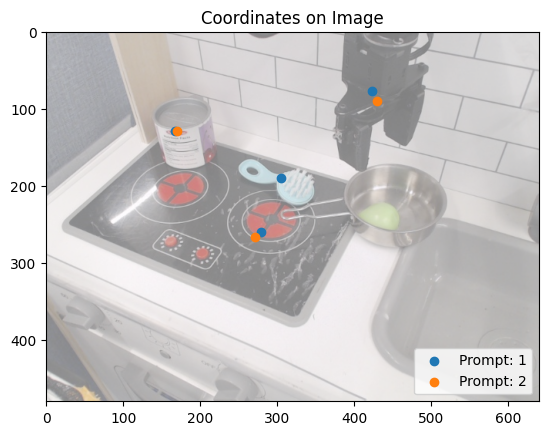



Task: Move the can from the top left of the burner to the bottom left of the burner
confidence: 0.8

Different Prompts:


KeyboardInterrupt: 

In [58]:
for i in range(len(tasks)):
    print(f"Task: {task}")
    image = images[i]
    task = tasks[i]
    
    labels = []
    outputs = []
    print("Different Prompts:")
    for j in range(len(prompts)):
        labels.append(f"Prompt: {j + 1}")
        prompt = prompt_start + task + prompts[j] + prompt_end
        
        
        output, likelihood = do_inference_and_log_likelihood(image, prompt)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Prompt: {j + 1} - Output: {molmo_out.get_generated_text()}")
        print(f"The log-likelihood is: {likelihood}")

    
    visualize_points_on_image(image, labels, outputs)
    print("")
    print("")

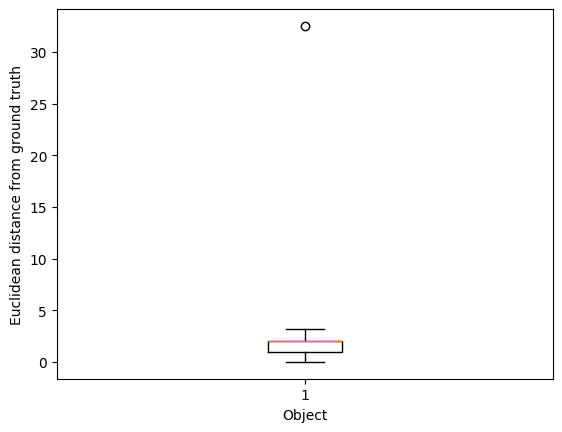

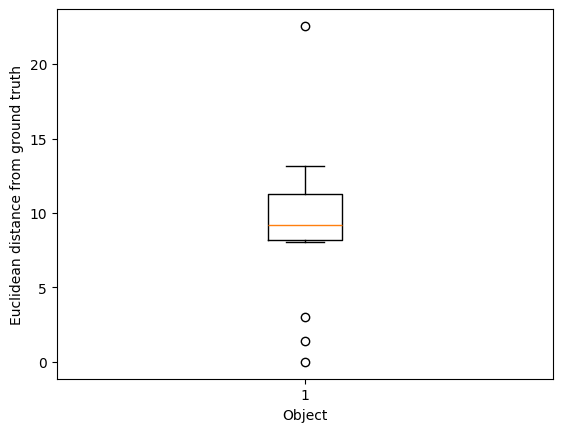

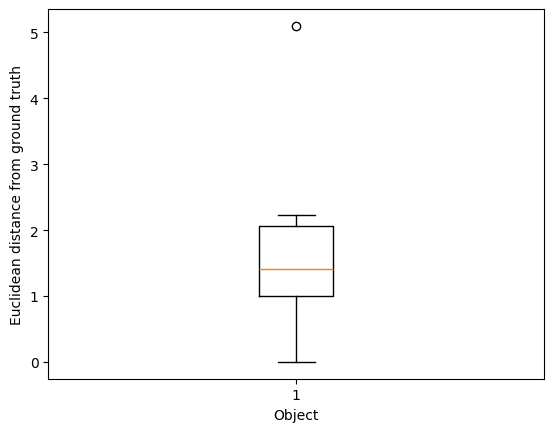

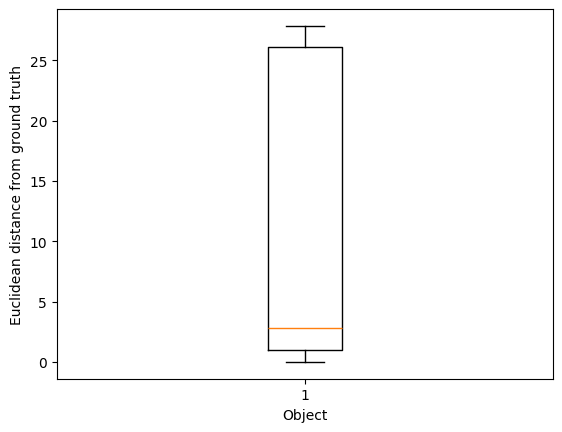

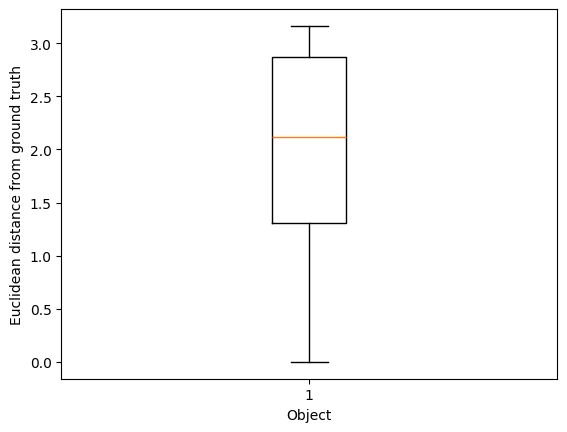

In [56]:
points, gts = group_objects(objects_of_all_prompts)
calculate_metric(points, gts)

Task: open low fridge

Different Prompts:
Prompt: 1 - Output:  (can, (26.5, 26.3)), (burner, (41.1, 48.3)), (robot arm, (68.2, 11.2)), (spatula, (47.1, 38.5))
Prompt: 2 - Output:  (can, (26.0, 27.8)), (burner, (40.9, 52.0)), (robot arm, (66.1, 15.1))


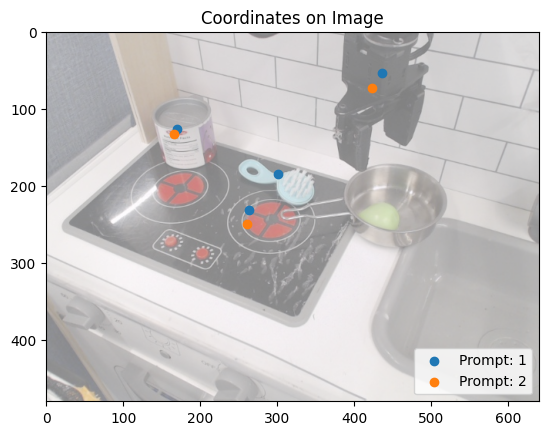



Multiple runs:
Run: 1 - Output:  (can, (26.1, 27.6)), (burner, (41.0, 51.1)), (robot arm, (67.1, 14.0)), (pot, (72.1, 49.0))
Run: 2 - Output:  (can, (27.1, 27.1)), (burner, (40.9, 49.6)), (robot arm, (67.3, 14.7)), (spatula, (47.6, 38.9)), (pot, (71.6, 48.8))
Run: 3 - Output:  (can, (27.0, 28.5)), (burner, (42.4, 50.8)), (robot arm, (66.5, 16.6)), (pot, (71.2, 48.6))
Run: 4 - Output:  (can, (26.5, 26.7)), (burner, (42.1, 57.4)), (robot arm, (68.5, 16.9)), (spatula, (46.7, 38.5)), (pot, (71.8, 47.5))


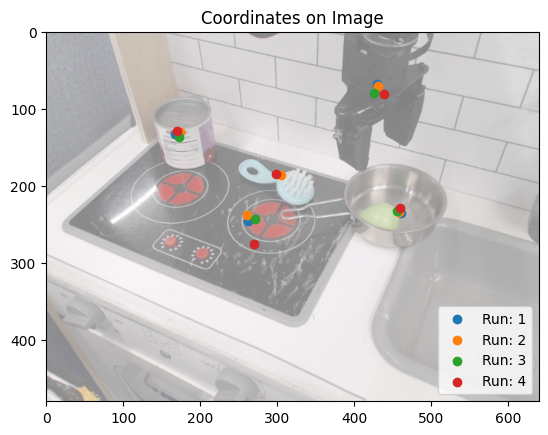



Testing different Temperatures:
Temperature: 0.3 - Output:  (can, (27.8, 26.7)), (burner, (45.1, 48.8)), (robot arm, (67.5, 15.8)), (pot, (72.7, 44.5))
Temperature: 0.4 - Output:  (can, (26.9, 29.2)), (burner, (40.5, 57.3)), (robot arm, (65.1, 14.8)), (pot, (69.9, 46.8))
Temperature: 0.6 - Output:  (can, (27.9, 26.8)), (burner, (41.7, 42.2)), (robot arm, (68.5, 17.5)), (spatula, (52.0, 45.7))
Temperature: 0.7 - Output:  (can, (26.7, 26.1)), (burner, (44.0, 59.8)), (robot arm, (67.7, 9.4)), (kitchen counter, (61.8, 74.4)), (sink, (86.5, 79.5))


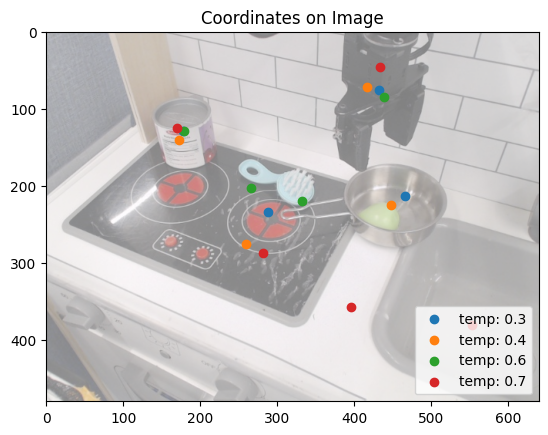



Task: Move the can from the top left of the burner to the bottom left of the burner
confidence: 0.8

Different Prompts:
Prompt: 1 - Output:  (red screwdriver, (34.1, 37.9)), (red screwdriver, (34.6, 40.7)), (robot arm, (73.6, 16.3)), (red toolbox, (50.7, 20.1))
Prompt: 2 - Output:  (red screwdriver, (41.4, 36.3)), (red screwdriver, (41.4, 40.4)), (red screwdriver, (46.1, 33.9)), (red screwdriver, (69.4, 69.9)), (robot arm, (68.1, 10.2))


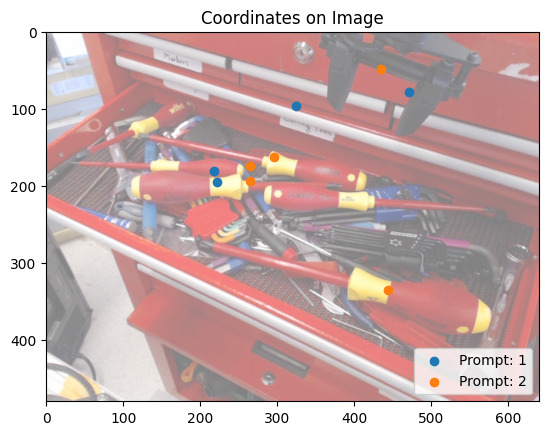



Multiple runs:
Run: 1 - Output:  (red screwdriver, (40, 38)), (robot arm, (70, 15)), (red toolbox, (50, 20)), (white floor, (15, 80)), (wrench, (90, 85))
Run: 2 - Output:  (red screwdriver, (42, 38)), (robot arm, (68.8, 13.4)), (red toolbox, (89.0, 20.8))
Run: 3 - Output:  (red screwdriver, (33.3, 36.5)), (red screwdriver, (33.3, 41.2)), (robot arm, (76.5, 15.6)), (red toolbox, (50.0, 50.0))
Run: 4 - Output:  (red screwdriver, (40, 37)), (red screwdriver, (43, 40)), (red screwdriver, (68, 70)), (robot arm, (71.9, 18.1))


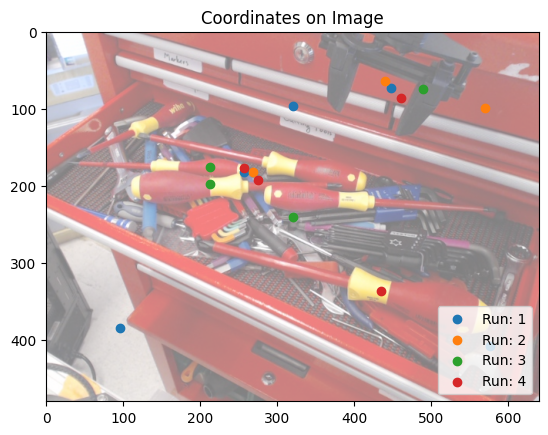



Testing different Temperatures:
Temperature: 0.3 - Output:  (red screwdriver, (23.9, 22.9)), (robot arm, (70.2, 10.5)), (red toolbox, (53.9, 33.2))
Temperature: 0.4 - Output:  (red screwdriver, (41.2, 32.6)), (robot arm, (74.3, 14.4)), (red toolbox, (55.2, 16.3)), (red toolbox drawer, (56.4, 83.9)), (screwdrivers, (41.2, 32.6)), (screwdrivers, (78.1, 74.9))
Temperature: 0.6 - Output:  (red screwdriver, (41.3, 34.5)), (toolbox drawer, (50.0, 50.0)), (robot arm, (67.4, 10.9))
Temperature: 0.7 - Output:  (red screwdriver, (35, 37)), (robot arm, (82.1, 10.1)), (red toolbox, (83.5, 16.3))


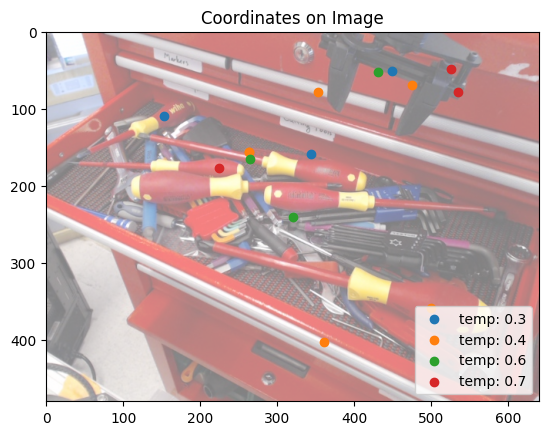



Task: pick up red srewdriver

Different Prompts:
Prompt: 1 - Output:  (eggplant, (54.5, 45.4)), (robot arm, (56.4, 21.4)), (orange bowl, (62.2, 47.6))
Prompt: 2 - Output:  (eggplant, (52.9, 45.1)), (orange bowl, (60.6, 48.2)), (robot arm, (54.4, 25.1))


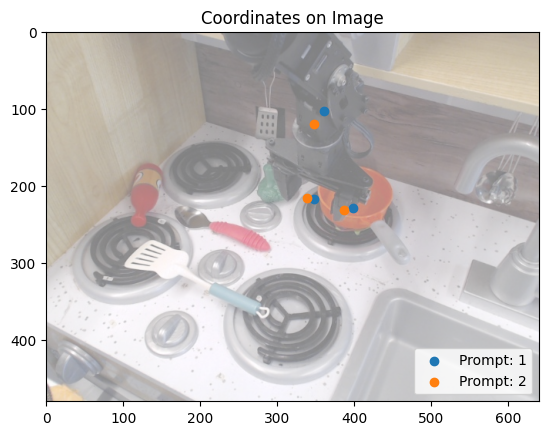



Multiple runs:
Run: 1 - Output:  (eggplant, (51.3, 44.6)), (robot arm, (57.1, 21.1)), (orange bowl, (60.5, 48.6)), (burners, (61.1, 54.7), (61.4, 76.1))
Run: 2 - Output:  (eggplant, (47.5, 42.0)), (robot arm, (56.0, 26.6)), (orange bowl, (61.1, 46.9)), (burners, (59.8, 56.2), (59.8, 78.2))
Run: 3 - Output:  (eggplant, (46.0, 44.2)), (robot arm, (56.4, 22.6)), (orange bowl, (60.2, 47.6)), (burners, (60.2, 56.2))
Run: 4 - Output:  (eggplant, (51.9, 43.2)), (robot arm, (55.6, 22.9)), (orange bowl, (61.0, 48.0)), (burners, (59.1, 55.6), (59.1, 76.6))


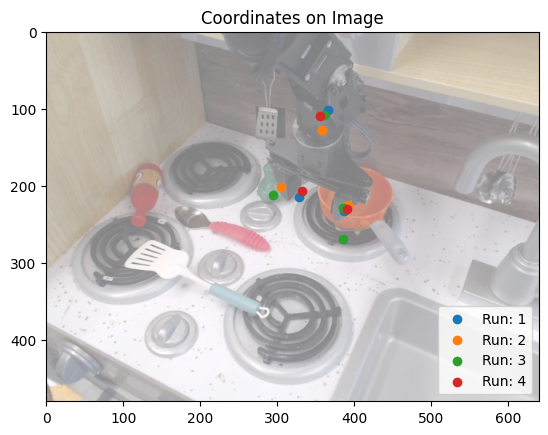



Testing different Temperatures:
Temperature: 0.3 - Output:  (eggplant, (46.8, 44.3)), (orange bowl, (61.4, 47.2)), (robot arm, (55.6, 20.2))
Temperature: 0.4 - Output:  (eggplant, (54.4, 43.2)), (robot arm, (56.0, 23.5)), (orange bowl, (62.1, 47.8)), (burner, (56.8, 56.9)), (burner, (60.5, 52.4))
Temperature: 0.6 - Output:  (eggplant, (51.1, 42.0)), (orange bowl, (58.3, 44.2)), (robot arm, (56.0, 20.5))
Temperature: 0.7 - Output:  (eggplant, (57.0, 50.1)), (robot arm, (58.5, 14.6)), (orange bowl, (63.8, 46.7))


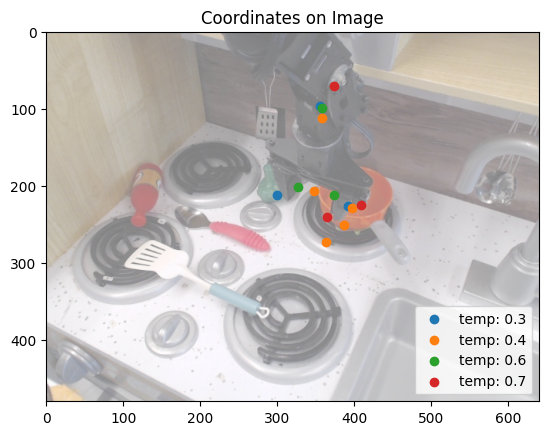



Task: take the eggplant and put it between the two right burners
confidence: 0.6

Different Prompts:
Prompt: 1 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))
Prompt: 2 - Output:  (arch, (42.1, 73.9)), (arch, (45.5, 63.6)), (tube, (70.5, 80.4))


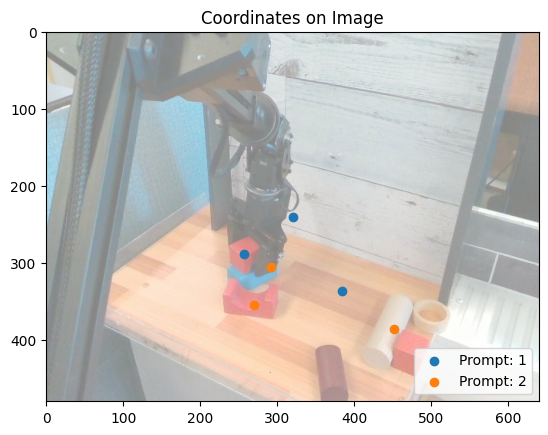



Multiple runs:
Run: 1 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))
Run: 2 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))
Run: 3 - Output:  (arch, (59.7, 89.5)), (arch, (69.0, 80.0)), (robot arm, (45.0, 47.3))
Run: 4 - Output:  (robot arm, (50, 50)), (arch, (40, 60)), (arch, (60, 70))


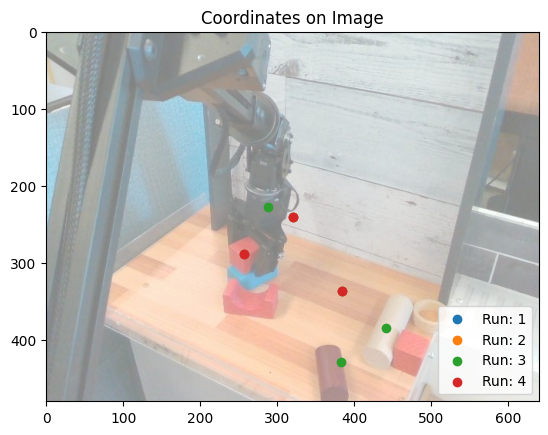



Testing different Temperatures:
Temperature: 0.3 - Output:  (robot arm, (50, 50)), (arch, (45, 88)), (arch, (45, 95)), (tube, (70, 82))
Temperature: 0.4 - Output:  (robot arm, (49.3, 36.2)), (arch, (42.6, 71.2)), (arch, (69.5, 83.2)), (tube, (69.5, 80.4))
Temperature: 0.6 - Output:  (robot arm, (50, 50)), (arch 1, (40, 60)), (arch 2, (45, 75)), (tube, (68, 80)), (bowl, (75, 76))
Temperature: 0.7 - Output:  (robot arm, (50, 45)), (arch, (70, 85)), (blue arch, (41, 70))


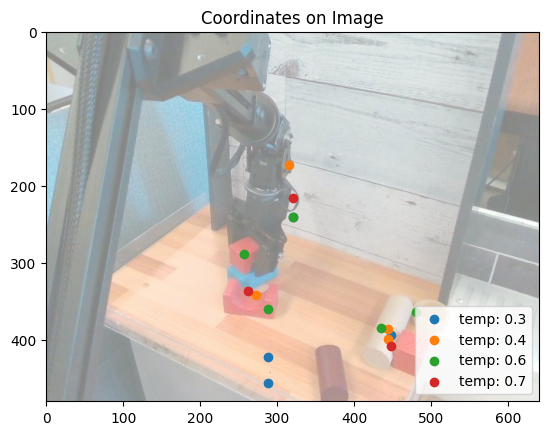



Task: move arch on the table and place it on top of another arch
confidence: 0.4

Different Prompts:
Prompt: 1 - Output:  (pan, (34.0, 26.4)), (sushi, (32.1, 22.4)), (robot arm, (59.8, 37.5)), (carrot, (15.4, 19.6))
Prompt: 2 - Output:  (pan, (35.1, 26.0)), (sushi, (30.3, 23.5)), (robot arm, (59.2, 38.8))


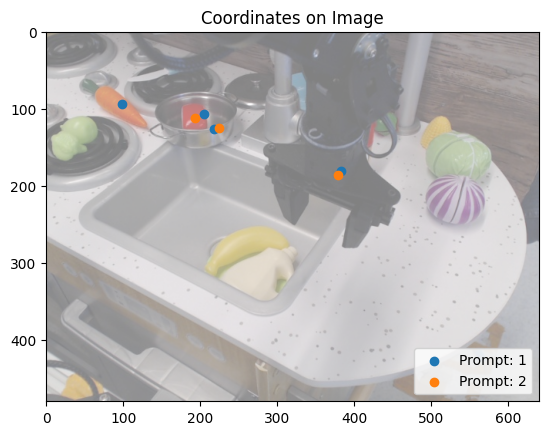



Multiple runs:
Run: 1 - Output:  (pan, (34.1, 26.0)), (sushi, (31.7, 23.3)), (robot arm, (58.6, 38.3))
Run: 2 - Output:  (pan, (33.4, 26.5)), (sushi, (31.3, 22.7)), (robot arm, (54.6, 35.0))
Run: 3 - Output:  (pan, (34.5, 26.8)), (sushi, (32.6, 22.7)), (robot arm, (59.5, 36.7))
Run: 4 - Output:  (pan, (32.6, 25.2)), (sushi, (32.6, 25.2)), (robot arm, (59.3, 26.4)), (carrot, (15.4, 19.5))


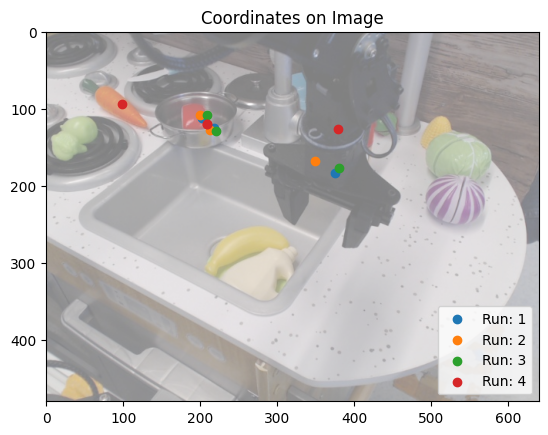



Testing different Temperatures:
Temperature: 0.3 - Output:  (pan, (32.1, 27.3)), (sushi, (32.3, 22.5)), (robot arm, (59.7, 35.2)), (carrot, (16.0, 19.5))
Temperature: 0.4 - Output:  (sushi pan, (32.1, 26.2)), (robot arm, (57.7, 25.9)), (sushi, (32.1, 26.2)), (sushi, (39.2, 57.5))
Temperature: 0.6 - Output:  (silver pan, (24, 18)), (sushi, (29, 22)), (robot arm, (56.3, 34.3))
Temperature: 0.7 - Output:  (sushi pan, (31.0, 25.7)), (sushi, (32.8, 24.8)), (robot arm, (59.5, 40.0)), (sink, (35.2, 48.8))


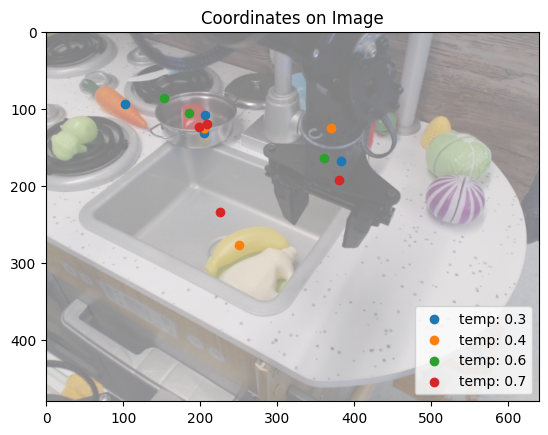



Task: take sushi out of pan

Different Prompts:


KeyboardInterrupt: 

In [33]:
"""
Das ist mein Script, dass die Experimente ausführt
Für alle tasks 3 mal das gleiche: 1. Für verschiedene prompts, 2. Für das gleiche prompt und gleiche temperature, 3. Für verschiedene temperatures 
"""

#tasks, images = extract_tasks_and_images("./data")
tasks, images = extract_tasks_and_images("./data2")

for i in range(len(tasks)):
    print(f"Task: {task}")
    image = images[i]
    task = tasks[i]
    
    labels = []
    outputs = []
    print("Different Prompts:")
    for j in range(len(prompts)):
        labels.append(f"Prompt: {j + 1}")
        prompt = prompt_start + task + prompts[j] + prompt_end
        
        
        output = do_inference_on_image(image, prompt)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Prompt: {j + 1} - Output: {molmo_out.get_generated_text()}")

    
    visualize_points_on_image(image, labels, outputs)
    print("")
    print("")


    prompt = prompt_start + task + prompts[0] + prompt_end
    labels = []
    outputs = []
    print("Multiple runs:")
    for j in range(4):
        labels.append(f"Run: {j + 1}")
        
        output = do_inference_on_image(image, prompt)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Run: {j + 1} - Output: {molmo_out.get_generated_text()}")

    visualize_points_on_image(image, labels, outputs)
    print("")
    print("")

    labels = []
    outputs = []
    print("Testing different Temperatures:")
    for j in range(len(temperatures)):
        temp = temperatures[j]
        labels.append(f"temp: {temp}")
        
        output = do_inference_on_image(image, prompt, temp)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Temperature: {temp} - Output: {molmo_out.get_generated_text()}")

    visualize_points_on_image(image, labels, outputs)
    print("")
    print("")

Task: Move the can from the top left of the burner to the bottom left of the burner
confidence: 0.8

Locate several points within the vacant space for the following task: Move the can from the top left of the burner to the bottom left of the burner
confidence: 0.8
Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image.
Multiple Runs:
Prompt: 1 - Output:  To solve this problem, we need to consider the movement of the can from the top left to the bottom left of the burner. The can's movement will involve a diagonal translation across the burner surface. Here's a list of tuples representing several points within the vacant space for this task:

[(0.2, 0.8), (0.4, 0.7), (0.6, 0.6), (0.8, 0.5), (1.0, 0.4)]

These points represent a diagonal line from the top 

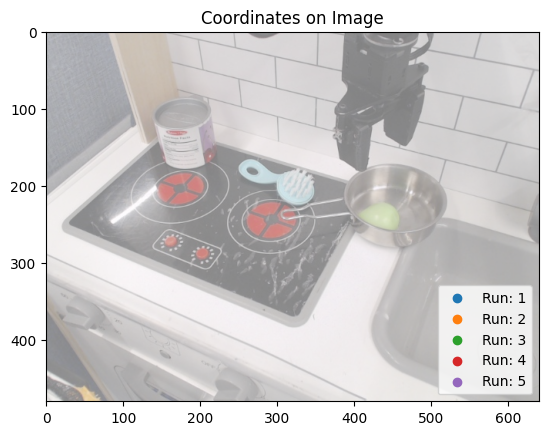



Task: Move the can from the top left of the burner to the bottom left of the burner
confidence: 0.8

Locate several points within the vacant space for the following task: pick up red srewdriver
Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image.
Multiple Runs:
Prompt: 1 - Output:  Here's a list of tuples representing points within the vacant space where you could pick up the red screwdriver:

[(0.1, 0.1), (0.2, 0.2), (0.3, 0.3), (0.4, 0.4), (0.5, 0.5), (0.6, 0.6), (0.7, 0.7), (0.8, 0.8), (0.9, 0.9), (1.0, 1.0)]

These points are spread across the empty area of the toolbox drawer, providing various options for grasping the red screwdriver while avoiding other tools and potential obstructions.
Prompt: 2 - Output:  Here's a list of tuples containing p

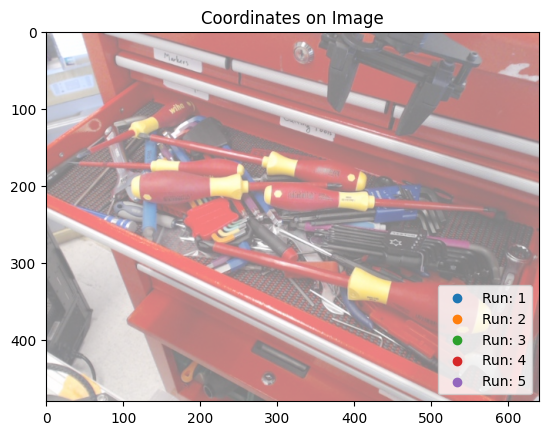



Task: pick up red srewdriver

Locate several points within the vacant space for the following task: take the eggplant and put it between the two right burners
confidence: 0.6
Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image.
Multiple Runs:
Prompt: 1 - Output:  [
Prompt: 2 - Output:  There are none.
Prompt: 3 - Output:  There are none.
Prompt: 4 - Output:  There are none.
Prompt: 5 - Output:  There are none.


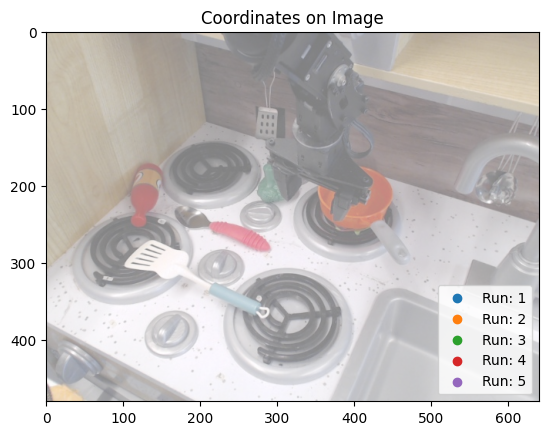



Task: take the eggplant and put it between the two right burners
confidence: 0.6

Locate several points within the vacant space for the following task: move arch on the table and place it on top of another arch
confidence: 0.4
Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image.
Multiple Runs:
Prompt: 1 - Output:  There are none.
Prompt: 2 - Output:  There are none.
Prompt: 3 - Output:  There are none.
Prompt: 4 - Output:  There are none.
Prompt: 5 - Output:  There are none.


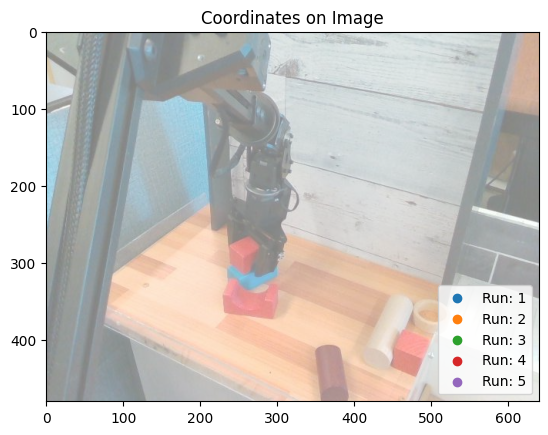



Task: move arch on the table and place it on top of another arch
confidence: 0.4

Locate several points within the vacant space for the following task: take sushi out of pan
Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image.
Multiple Runs:
Prompt: 1 - Output:  Here's a list of tuples representing points within the vacant space for the task of taking sushi out of the pan:

[(0.1, 0.1), (0.2, 0.2), (0.3, 0.3), (0.4, 0.4), (0.5, 0.5), (0.6, 0.6), (0.7, 0.7), (0.8, 0.8), (0.9, 0.9), (1.0, 1.0)]

These points are spread across the entire vacant area of the pan, providing a range of potential locations where the sushi could be found.
Prompt: 2 - Output:  Based on the image, here's a list of tuples representing points within the vacant space above the pa

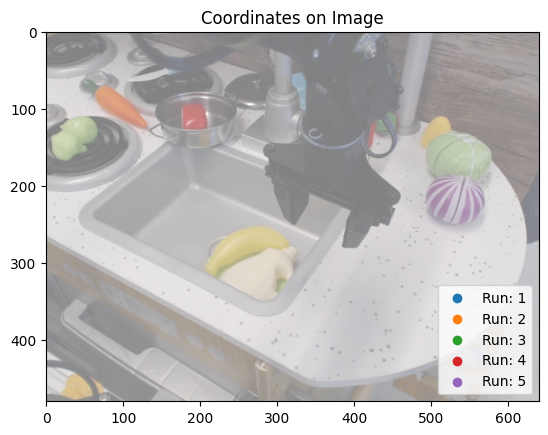



Task: take sushi out of pan

Locate several points within the vacant space for the following task: pick up glass cup
Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image.
Multiple Runs:
Prompt: 1 - Output:  Based on the image, here's a list of tuples representing several points within the vacant space for picking up a glass cup:

[(0.1, 0.1), (0.2, 0.2), (0.3, 0.3), (0.4, 0.4), (0.5, 0.5), (0.6, 0.6), (0.7, 0.7), (0.8, 0.8), (0.9, 0.9), (1.0, 1.0)]

These points are spread across the empty area of the dishwasher, providing various options for the robotic arm to grasp a glass cup from the vacant space.
Prompt: 2 - Output:  Based on the image, here are several points within the vacant space where the robotic arm could pick up a glass cup:

[(0.5, 0.5),

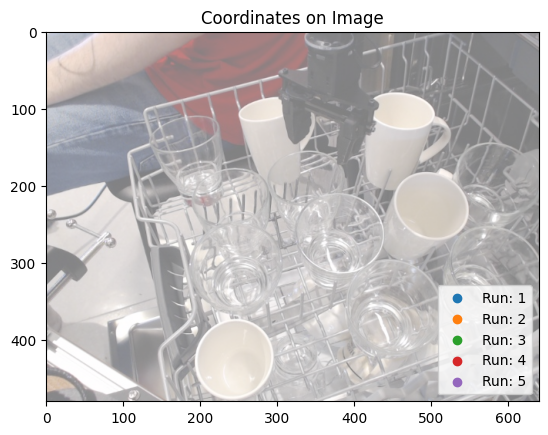



Task: pick up glass cup

Locate several points within the vacant space for the following task: open low fridge
Your answer should be formatted as a list of tuples, i.e. [(x1, y1), (x2, y2), ...], where each tuple contains the x and y coordinates of a point satisfying the conditions above. The coordinates should be between 0 and 1, indicating the normalized pixel locations of the points in the image.
Multiple Runs:
Prompt: 1 - Output:  Based on the image, here's a list of tuples representing points within the vacant space of the low fridge:

[(0.3, 0.5), (0.6, 0.4), (0.8, 0.3), (1.0, 0.2), (1.2, 0.1), (1.5, 0.0), (1.8, 0.5), (2.0, 0.4), (2.3, 0.3), (2.5, 0.2), (2.7, 0.1), (3.0, 0.6), (3.2, 0.5), (3.5, 0.4), (3.7, 0.3), (4.0, 0.2), (4.2, 0.7), (4.5, 0.
Prompt: 2 - Output:  Based on the image, here's a list of tuples representing points within the vacant space of the low fridge:

[(0.3, 0.2), (0.5, 0.4), (0.7, 0.6), (0.9, 0.8), (1.2, 1.0)]

These points are located within the gray squar

KeyboardInterrupt: 

In [32]:
tasks, images = extract_tasks_and_images("./data2")
for i in range(len(tasks)):
    print(f"Task: {task}")
    image = images[i]
    task = tasks[i]
    prompt = robo_point_prompt + task + robo_point_end
    print(prompt)
    
    labels = []
    outputs = []
    print("Multiple Runs:")
    for j in range(5):
        labels.append(f"Run: {j + 1}")
        
        output = do_inference_on_image(image, prompt)
        molmo_out = Molmo_out(output, image.width, image.height)
        outputs.append(molmo_out)
    
        print(f"Prompt: {j + 1} - Output: {molmo_out.get_generated_text()}")

    
    visualize_points_on_image(image, labels, outputs)
    print("")
    print("")